In [1]:
%load_ext autoreload
%autoreload 2

### **Imports**

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [49]:
from scripts.load_data import load_data
from scripts.preprocessing import missing_percentage_dataframe,group_by_ship_type,sort_by_missing_percentage,drop_columns_above_threshold,extract_technical_efficiency_value,calculate_correlation

### **Load Data**

In [29]:
data_path = "data/"

In [30]:
df = load_data(data_path)

2023-05-08 18:34:27,264 - INFO - Found 4 .xlsx files in data
2023-05-08 18:34:27,265 - INFO - Reading data/2020-v184-24042023-EU MRV Publication of information.xlsx
2023-05-08 18:34:34,858 - INFO - Reading data/2018-v268-06102022-EU MRV Publication of information.xlsx
2023-05-08 18:34:42,466 - INFO - Reading data/2019-v213-24042023-EU MRV Publication of information.xlsx
2023-05-08 18:34:50,552 - INFO - Reading data/2021-v146-01052023-EU MRV Publication of information.xlsx
2023-05-08 18:34:58,209 - INFO - Combined 4 .xlsx files into a single DataFrame


In [31]:
df.head()

,IMO Number,Name,Ship type,Reporting Period,Technical efficiency,Port of Registry,Home Port,Ice Class,DoC issue date,DoC expiry date,...,CO₂ emissions per distance on laden voyages [kg CO₂ / n mile],CO₂ emissions per transport work (mass) on laden voyages [g CO₂ / m tonnes · n miles],CO₂ emissions per transport work (volume) on laden voyages [g CO₂ / m³ · n miles],CO₂ emissions per transport work (dwt) on laden voyages [g CO₂ / dwt carried · n miles],CO₂ emissions per transport work (pax) on laden voyages [g CO₂ / pax · n miles],CO₂ emissions per transport work (freight) on laden voyages [g CO₂ / m tonnes · n miles],Additional information to facilitate the understanding of the reported average operational energy efficiency indicators,Average density of the cargo transported [m tonnes / m³],Annual Total time spent at sea [hours],Total time spent at sea [hours]
0,6602898,OCEAN MAJESTY,Passenger ship,2020,EIV (31.73 gCO₂/t·nm),Madeira,NaN,NaN,01/07/2021,30/06/2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6703343,EQUALITY,Other ship types,2020,EIV (57.84 gCO₂/t·nm),Beirut,NaN,NaN,30/06/2021,30/06/2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7037806,IONIAN STAR,Ro-pax ship,2020,EIV (19.4 gCO₂/t·nm),NaN,NaN,NaN,31/03/2021,30/06/2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7043843,TALOS,Ro-ro ship,2020,EIV (48.71 gCO₂/t·nm),Piraeus,Piraeus,NaN,16/06/2021,30/06/2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7128332,SEA WIND,Ro-pax ship,2020,EIV (9.29 gCO₂/t·nm),Tallinn,Tallinn,IB,26/04/2021,30/06/2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Preprocessing**

#### Dealing with Columns containing nan values

In [32]:
missing_percentage_df = missing_percentage_dataframe(df)
sorted_missing_percentage_df = sort_by_missing_percentage(missing_percentage_df)
sorted_missing_percentage_df

2023-05-08 18:34:58,460 - INFO - Creating a DataFrame containing the missing percentage for each column
2023-05-08 18:34:58,461 - INFO - Calculating missing percentage for each column in the DataFrame
2023-05-08 18:34:58,646 - INFO - Sorting DataFrame by 'Missing Percentage' column in descending order


,Missing Percentage
CO₂ emissions per transport work (freight) on laden voyages [g CO₂ / m tonnes · n miles],100.000000
Fuel consumption per transport work (freight) on laden voyages [g / m tonnes · n miles],100.000000
Average density of the cargo transported [m tonnes / m³],99.989785
D,99.987742
Fuel consumption per transport work (pax) on laden voyages [g / pax · n miles],99.965268
...,...
CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes],0.000000
CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes],0.000000
Name,0.000000
Annual average Fuel consumption per distance [kg / n mile],0.000000


I want columns where the % of missing data is less than 4%

In [33]:
sorted_missing_percentage_df[sorted_missing_percentage_df["Missing Percentage"] < 4]

,Missing Percentage
Technical efficiency,3.467086
Verifier City,0.000000
Ship type,0.000000
Reporting Period,0.000000
DoC issue date,0.000000
DoC expiry date,0.000000
Verifier Name,0.000000
Verifier NAB,0.000000
Verifier Address,0.000000
Verifier Accreditation number,0.000000


Based on the above, I want to narrow my choices down to the following options in order to simplify Analysis. <br/>
Some of the columns above are also highly correlated as we'll soon see below

In [34]:
columns_to_keep = [
"Name",
"Ship type",
"Reporting Period",
"DoC issue date",
"DoC expiry date",
"Annual average CO₂ emissions per distance [kg CO₂ / n mile]",
"Total CO₂ emissions [m tonnes]",
"Technical efficiency",'Total fuel consumption [m tonnes]'
]

In [35]:
df = df[columns_to_keep]

### **Basic Exploratory Data Analysis**

In [52]:
from scripts.plots import plot_ship_type_counts,plot_emissions_profiles,plot_emissions,plot_relationship,plot_bar_plot

#### How Many Ships of each type are there?

In [37]:
ship_type_counts = df["Ship type"].value_counts()

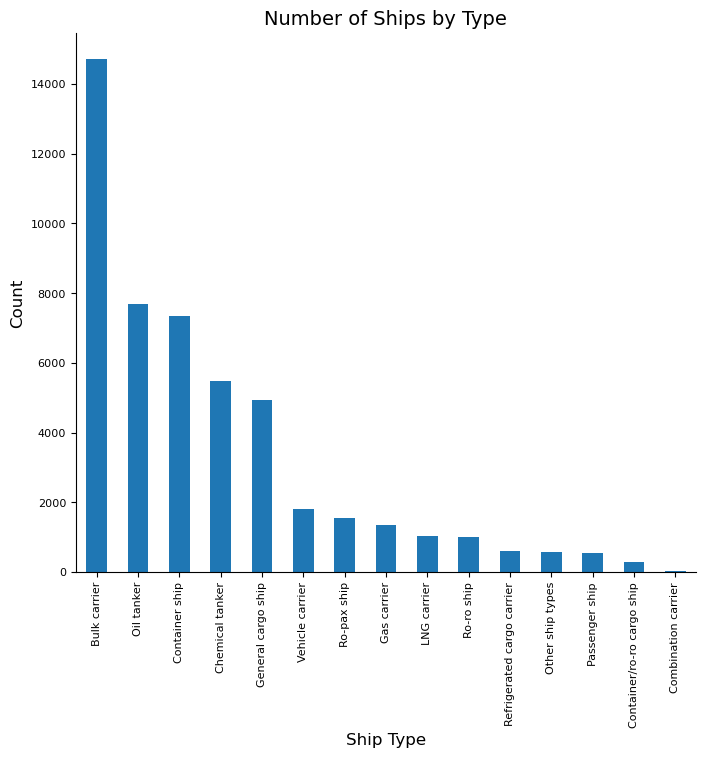

In [38]:
plot_ship_type_counts(ship_type_counts)

#### How do the emissions profiles differ for the different ship types

This box plot shows the distribution of 'Total CO₂ emissions [m tonnes]' for each ship type. It can be interpreted as the differences in emissions profiles by comparing the median, quartiles, and outliers of the box plots for each ship type.

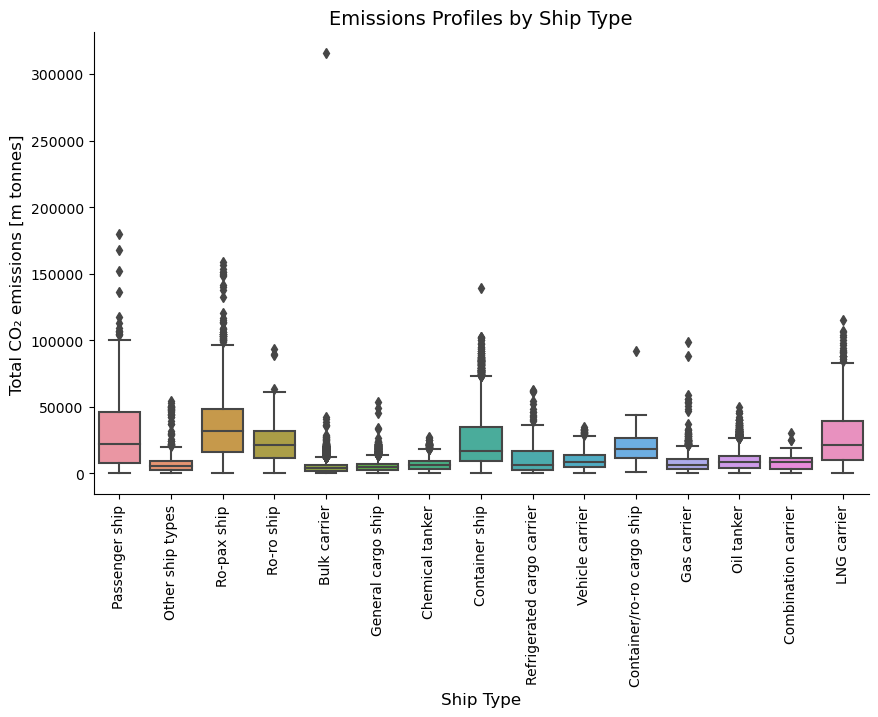

In [39]:
plot_emissions_profiles(df)

#### YoY Emissions Trend

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

def prepare_data(df):
    df['Year'] = df['Reporting Period'].astype('category')
    annual_emissions = df.groupby('Year')['Total CO₂ emissions [m tonnes]'].sum().reset_index()
    return annual_emissions

In [41]:
annual_emissions = prepare_data(df)

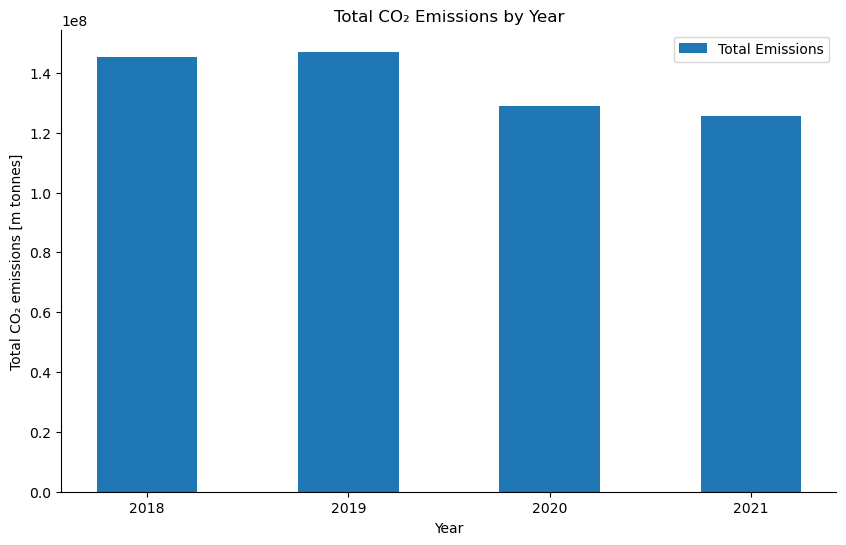

In [42]:
plot_emissions(annual_emissions)

#### Relationship between Total fuel consumption [m tonnes] and Total CO₂ emissions [m tonnes]

In [43]:
correlation = calculate_correlation(df)

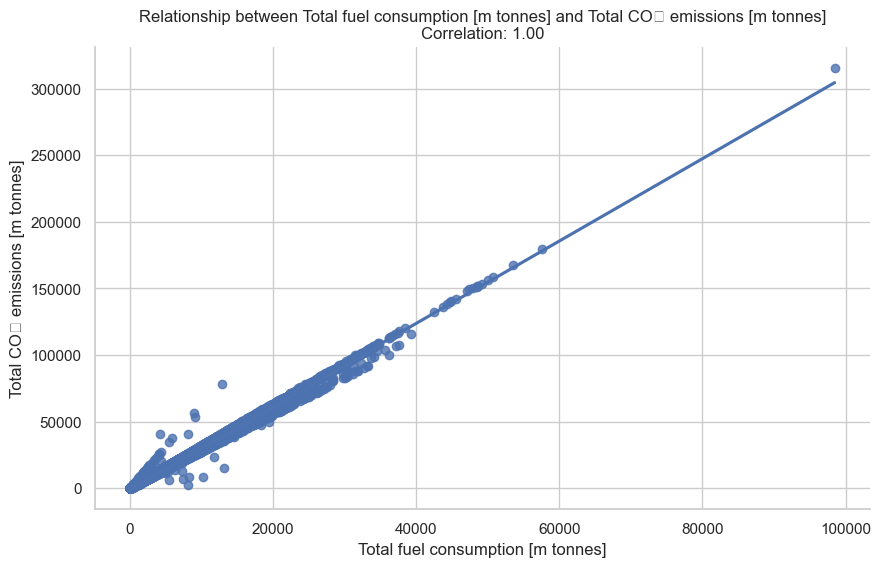

In [46]:
plot_relationship(df, correlation)

The scatter plot displays the relationship between the two variables: 'Total fuel consumption [m tonnes]' (x-axis) and 'Total CO₂ emissions [m tonnes]' (y-axis). Each point in the plot represents an observation in the dataset, with the x-coordinate representing the fuel consumption and the y-coordinate representing the CO₂ emissions.

The straight line (regression line) is a best-fit line that describes the linear relationship between the two variables. The line is calculated using a method called "least squares," which minimizes the sum of the squared differences between the observed values and the values predicted by the line.

Since the points are closely packed around the line and the line has a positive slope, we can say there is a strong linear relationship between the two variables. That is, As the total fuel consumption increases, the total CO₂ emissions also increase.

#### Technical efficiency of ship types

In [48]:
df = extract_technical_efficiency_value(df, 'Technical efficiency', 'Technical efficiency value')

In [50]:
grouped_df = group_by_ship_type(df, 'Technical efficiency value')

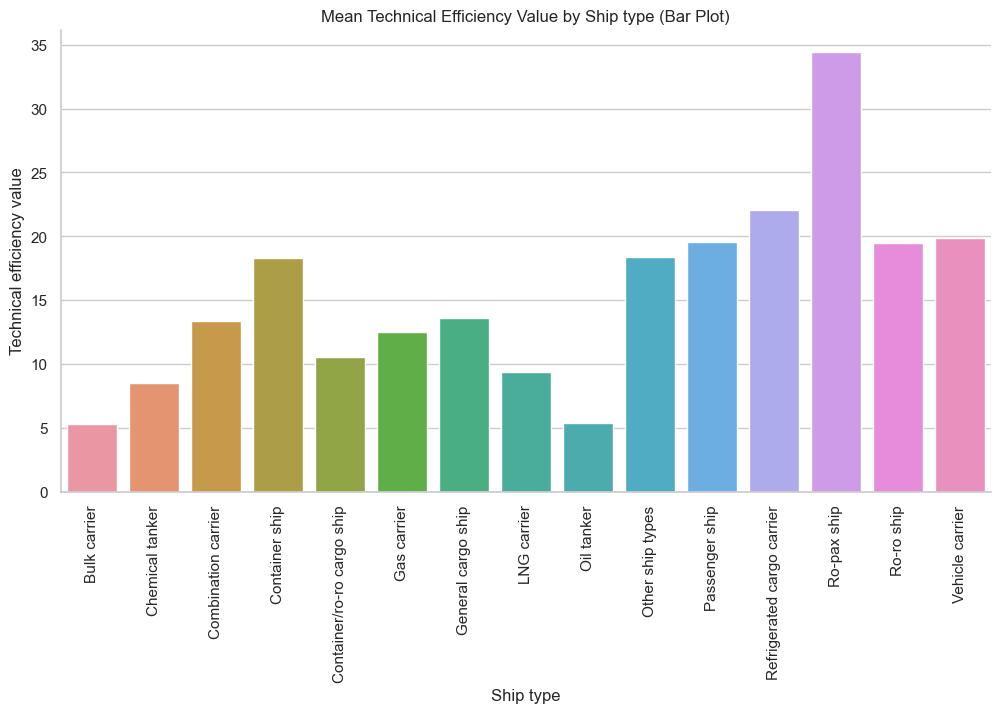

In [53]:
plot_bar_plot(grouped_df, 'Ship type', 'Technical efficiency value')